Examine whether SD results in lower theta frequency during reMAZE, which would reflect environmental novely (Jeewajee et al., 2008, Hippocampus).

In [1]:
%load_ext autoreload
%autoreload 2
import sys
import platform
from pathlib import Path
from os import environ
if platform.system() == "Darwin": # Nat laptop
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])
    # sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/sleep_deprivation/DataPaths/'])
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/sd_paper/analysis_and_figure_code/DataPaths'])
    plot_dir = Path("/Users/nkinsky/Documents/UM/Working/Bapun_Data/plots")
else:
    if environ["HOSTNAME"] == "lnx00004": # Nat Linux computer
        sys.path.extend(['/data/GitHub/NeuroPy'])
        sys.path.extend(['/data/GitHub/sleep_loss_hippocampal_replay/analysis_and_figure_code/DataPaths'])
        plot_dir = Path('/data/Clustering/plots')
    else:  #BG computer
        sys.path.extend(['/home/nkinsky/Documents/GitHub/NeuroPy'])
        sys.path.extend(['/home/nkinsky/Documents/GitHubPrivate/pythonprogs/DataPaths/'])

group_data_dir = Path('/data/Clustering/grpdata')
    
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import scipy.signal as sg
import matplotlib.pyplot as plt
from neuropy.utils.mathutil import min_max_scaler
from scipy.ndimage import gaussian_filter1d, gaussian_filter
from copy import deepcopy
from tqdm import tqdm

from neuropy import plotting
from neuropy.analyses.placefields import Pf1D, Pf1Dsplit
from neuropy.analyses.oscillations import detect_theta_epochs
from neuropy.core.position import Position
from neuropy.core.epoch import Epoch
from neuropy.plotting.ratemaps import plot_ratemap
from neuropy.plotting.figure import Fig
from neuropy.utils.misc import flatten
from neuropy.io import BinarysignalIO

import subjects
from plotters import Plotter, get_nsd_vs_sd_df, add_parametric_extras, stats_to_df, filter_stats_df
from stats_utils import get_bootstrap_prob, get_bootstrap_prob_paired

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [2]:
sessions = subjects.remaze_sess()

### Plot example session
No speed thresholding yet

(0.5, 14.0)

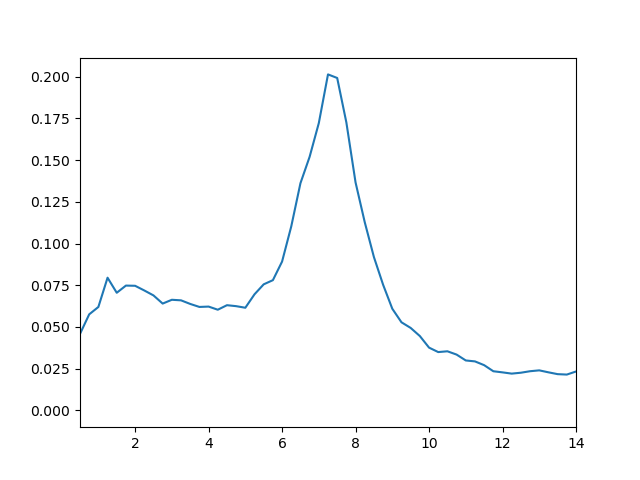

In [9]:
%matplotlib widget
sess = sessions[2]
eegtheta_file = sorted(sess.recinfo.dat_filename.parent.glob("*_thetachan.eeg"))[0]
sess.thetachan_eeg = BinarysignalIO(eegtheta_file, n_channels=1, sampling_rate=sess.recinfo.eeg_sampling_rate)
signal = sess.thetachan_eeg.get_signal()
maze = sess.paradigm["maze"].flatten()
trace_use = signal.time_slice(t_start=maze[0], t_stop=maze[1]).traces[0]
f, pxx = sg.welch(trace_use, fs=sess.thetachan_eeg.sampling_rate, nperseg=4 * sess.recinfo.eeg_sampling_rate, noverlap=0)
pxx = pxx * (0.95 * 1e-3) ** 2

## Plot it
_, ax = plt.subplots()
ax.plot(f, pxx)
ax.set_xlim([0.5, 14])

### Get PSD for each session
no speed thresholding

In [10]:
speed_thresh = 3
sigma = 0.5 # in seconds
psd_df = []
for sess in sessions[1:]:
    eegtheta_file = sorted(sess.recinfo.dat_filename.parent.glob("*_thetachan.eeg"))[0]
    sess.thetachan_eeg = BinarysignalIO(eegtheta_file, n_channels=1, sampling_rate=sess.recinfo.eeg_sampling_rate)
    signal = sess.thetachan_eeg.get_signal()
    for sname in ["maze", "re-maze"]:
        tmaze = sess.paradigm[sname].flatten()
        trace_use = signal.time_slice(t_start=tmaze[0], t_stop=tmaze[1]).traces[0]
        f, pxx = sg.welch(trace_use, fs=sess.thetachan_eeg.sampling_rate, nperseg=4 * sess.recinfo.eeg_sampling_rate, noverlap=0)
        pxx = pxx * (0.95 * 1e-3) ** 2
    
        psd_df.append(pd.DataFrame(dict(session=sname, f=f, pxx=pxx, grp=sess.tag)))
psd_df = pd.concat(psd_df, axis=0, ignore_index=True)
psd_df

,session,f,pxx,grp
0,maze,0.00,5.945352e-03,NSD
1,maze,0.25,1.024362e-02,NSD
2,maze,0.50,8.815681e-03,NSD
3,maze,0.75,1.191178e-02,NSD
4,maze,1.00,1.628149e-02,NSD
...,...,...,...,...
40011,re-maze,624.00,1.220091e-10,SD
40012,re-maze,624.25,1.215536e-10,SD
40013,re-maze,624.50,1.178225e-10,SD
40014,re-maze,624.75,1.177270e-10,SD


(-0.02, 0.2)

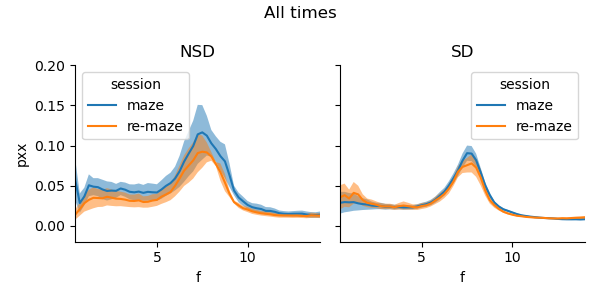

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3), sharex=True, sharey=True, layout="tight")
fig.suptitle('All times')

for grp, a in zip(["NSD", "SD"], ax):
    df_grp = psd_df[psd_df.grp == grp]
    sns.lineplot(data=df_grp, x="f", y="pxx", hue="session", errorbar=None, ax=a)
    a.set_xlim([0.5, 14])
    a.set_title(grp)

    df_grp2 = df_grp.drop(columns="grp").groupby(["session", "f"])
    mean_prob = df_grp2.mean(numeric_only=True).reset_index()
    sem_prob = df_grp2.sem(ddof=0, numeric_only=True).reset_index()

    for sname in ["maze", "re-maze"]:
        mean_use = mean_prob[mean_prob.session == sname]
        sem_use = sem_prob[sem_prob.session == sname]
        a.fill_between(mean_use.f, mean_use.pxx - sem_use.pxx, mean_use.pxx + sem_use.pxx, alpha=0.5)
    sns.despine(ax=a)
    
ax[0].set_ylim((-0.02, 0.20))

### Now with speed thresholding

In [30]:
from neuropy.utils.mathutil import contiguous_regions
sigma = 0.5 # in seconds, for smoothing position prior to calculating speed
psd_dict = {}
speed_thresh = 10

for speed_thresh in [1, 3, 5, 10]:
    psd_run_df = []
    for sess in sessions[1:]:
        eegtheta_file = sorted(sess.recinfo.dat_filename.parent.glob("*_thetachan.eeg"))[0]
        sess.thetachan_eeg = BinarysignalIO(eegtheta_file, n_channels=1, sampling_rate=sess.recinfo.eeg_sampling_rate)
        signal = sess.thetachan_eeg.get_signal()
        for sname in ["maze", "re-maze"]:
            tmaze = sess.paradigm[sname].flatten()
            trace_use = signal.time_slice(t_start=tmaze[0], t_stop=tmaze[1]).traces[0]

            # Speed threshold
            posmaze = sess.position.time_slice(*tmaze)
            pos_smooth = posmaze.get_smoothed(sigma)

            run_frames = contiguous_regions(pos_smooth.speed > speed_thresh)
            run_times = np.array([pos_smooth.time[run_f] for run_f in run_frames])

            trace_run = []
            for run_time in run_times:
                trace_run.append(signal.time_slice(t_start=run_time[0], t_stop=run_time[1]).traces[0])
            run_trace = np.hstack(trace_run)

            f, pxx = sg.welch(run_trace, fs=sess.thetachan_eeg.sampling_rate, 
                              nperseg=4 * sess.recinfo.eeg_sampling_rate, noverlap=0)
            pxx = pxx * (0.95 * 1e-3) ** 2

            psd_run_df.append(pd.DataFrame(dict(session=sname, f=f, pxx=pxx, grp=sess.tag)))
    psd_run_df = pd.concat(psd_run_df, axis=0, ignore_index=True)
    psd_dict[speed_thresh] = psd_run_df
psd_run_df

,session,f,pxx,grp
0,maze,0.00,9.197845e-04,NSD
1,maze,0.25,4.809540e-03,NSD
2,maze,0.50,8.517785e-03,NSD
3,maze,0.75,1.158402e-02,NSD
4,maze,1.00,1.481491e-02,NSD
...,...,...,...,...
40011,re-maze,624.00,4.710638e-08,SD
40012,re-maze,624.25,4.394508e-08,SD
40013,re-maze,624.50,4.423939e-08,SD
40014,re-maze,624.75,5.673334e-08,SD


/var/folders/7g/v7xwy2z52hxcjg7pfsxbb8zc0000gn/T/ipykernel_73171/628431173.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 2, figsize=(6, 3), sharex=True, sharey=True, layout="tight")


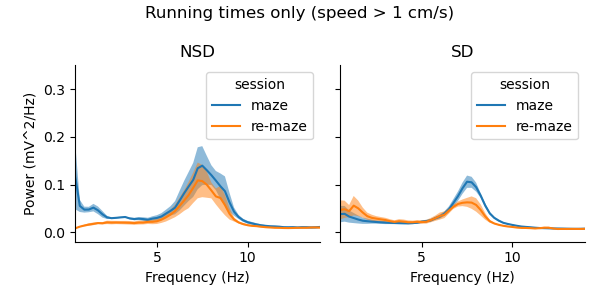

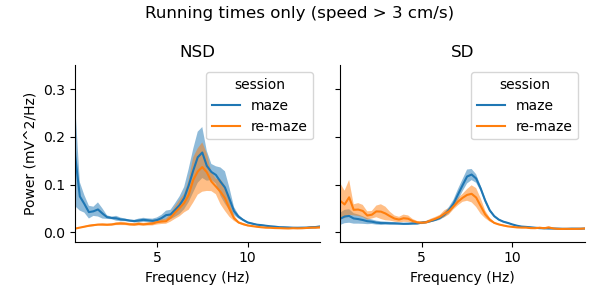

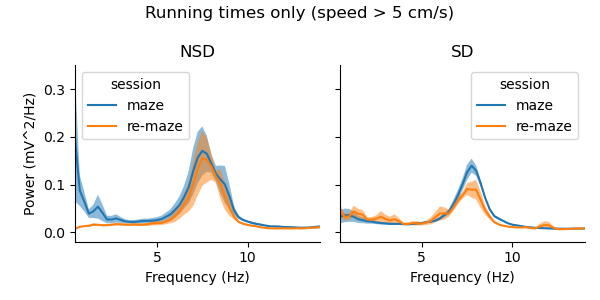

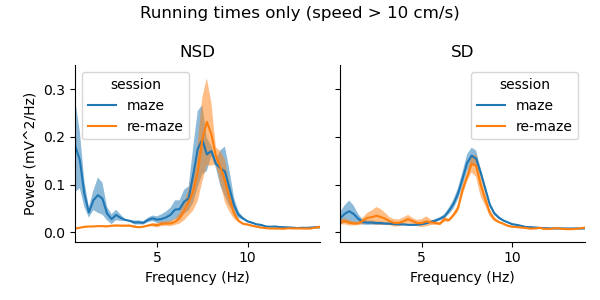

In [32]:
for speed_thresh, psd_run_df in psd_dict.items():
    fig, ax = plt.subplots(1, 2, figsize=(6, 3), sharex=True, sharey=True, layout="tight")
    fig.suptitle(f"Running times only (speed > {speed_thresh} cm/s)")

    for grp, a in zip(["NSD", "SD"], ax):
        df_grp = psd_run_df[psd_run_df.grp == grp]
        sns.lineplot(data=df_grp, x="f", y="pxx", hue="session", errorbar=None, ax=a)
        a.set_xlim([0.5, 14])
        a.set_title(grp)

        df_grp2 = df_grp.drop(columns="grp").groupby(["session", "f"])
        mean_prob = df_grp2.mean(numeric_only=True).reset_index()
        sem_prob = df_grp2.sem(ddof=0, numeric_only=True).reset_index()

        for sname in ["maze", "re-maze"]:
            mean_use = mean_prob[mean_prob.session == sname]
            sem_use = sem_prob[sem_prob.session == sname]
            a.fill_between(mean_use.f, mean_use.pxx - sem_use.pxx, mean_use.pxx + sem_use.pxx, alpha=0.5)
        sns.despine(ax=a)
        a.set_xlabel('Frequency (Hz)')
        a.set_ylabel('Power (mV^2/Hz)')

    ax[0].set_ylim((-0.02, 0.35))